# scATAC-seq marker features significance calculation

Here we will use scATAC-seq dataset "buenrostro2018" as an example to illustrate how SIMBA performs scATAC-seq marker feature significance calculation. Other analysis steps can be done as the same in "scATAC-seq analysis" tutorial.

In [2]:
import os
import simba as si
si.__version__

/srv/local/jayoung/conda/envs/jy_simba_copy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [3]:
workdir = 'result_simba_atacseq'
si.settings.set_workdir(workdir)

Saving results in: result_simba_atacseq


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_44426/3704955539.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### load example data

In [5]:
adata_CP = si.datasets.atac_buenrostro2018()

In [6]:
adata_CP

AnnData object with n_obs × n_vars = 2034 × 237450
    obs: 'celltype'
    var: 'chr', 'start', 'end'

### preprocessing

In [7]:
si.pp.filter_peaks(adata_CP,min_n_cells=3)

Before filtering: 
2034 cells, 237450 peaks
Filter peaks based on min_n_cells
After filtering out low-expressed peaks: 
2034 cells, 200167 peaks


In [8]:
si.pp.cal_qc_atac(adata_CP)

different ways to visualize the QC metrics

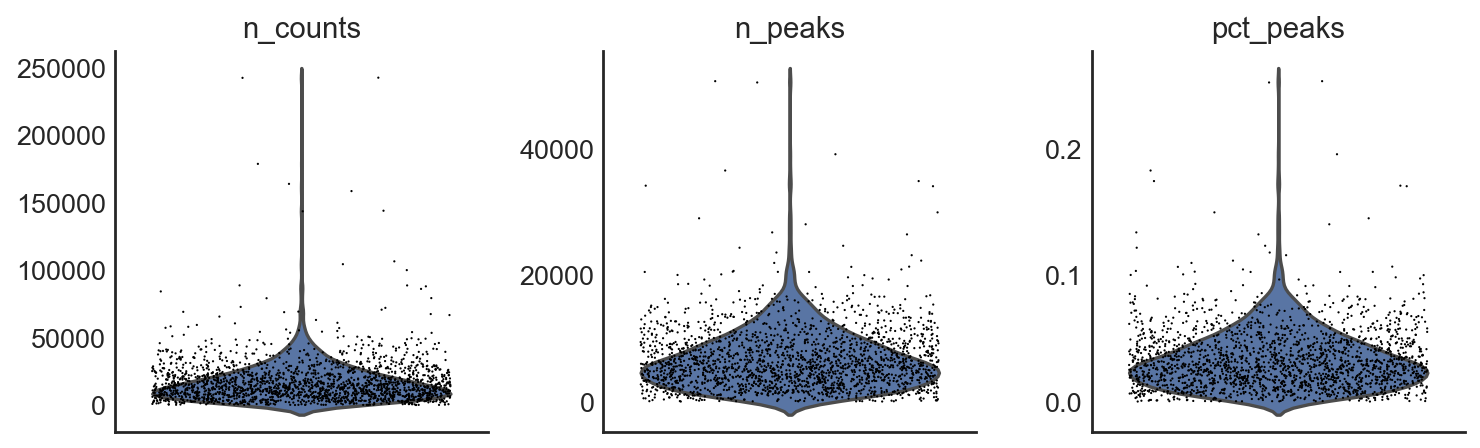

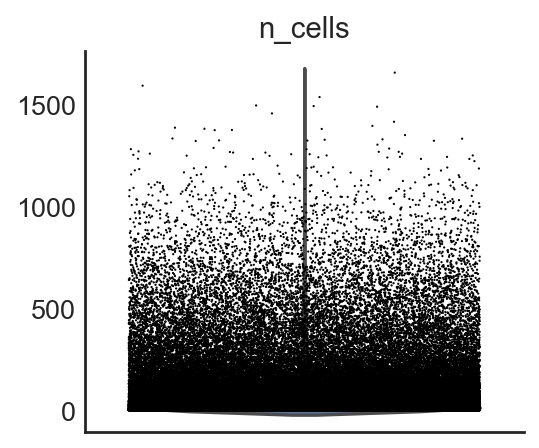

In [9]:
si.pl.violin(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], list_var=['n_cells'],fig_size=(3,3))

Filter out cells if needed:

```python
si.pp.filter_cells_atac(adata_CP,min_n_peaks=100)
```

### select peaks (optional)

It will speed up the trainning process by only keeping peaks associated with top PCs

In [10]:
si.pp.pca(adata_CP, n_components=50)

the number of selected PC is: 50


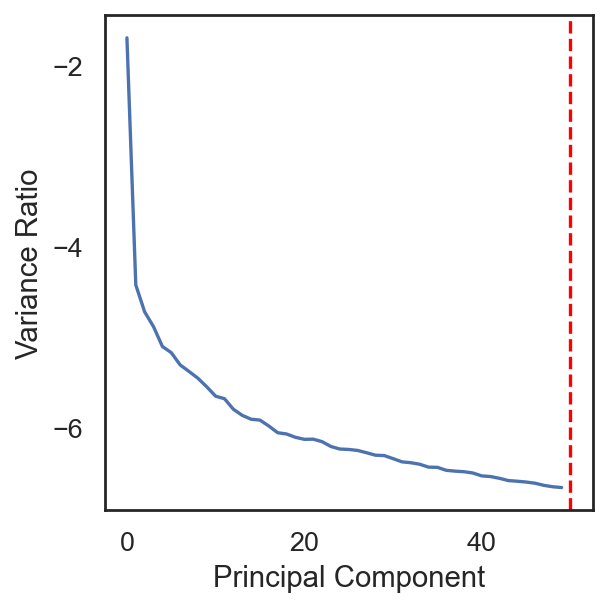

In [11]:
si.pl.pca_variance_ratio(adata_CP, show_cutoff=True)

The number of selected PCs can be further reduced:

```python
si.pp.select_pcs(adata_CP,n_pcs=30)
```

Select features associated with each of these PCs. The number of features for each PC will be automatically decided

In [12]:
si.pp.select_pcs_features(adata_CP)

#features selected from PC 0: 33368
#features selected from PC 1: 33415
#features selected from PC 2: 33361
#features selected from PC 3: 33397
#features selected from PC 4: 33375
#features selected from PC 5: 33431
#features selected from PC 6: 33395
#features selected from PC 7: 33442
#features selected from PC 8: 33372
#features selected from PC 9: 33376
#features selected from PC 10: 33364
#features selected from PC 11: 33393
#features selected from PC 12: 33372
#features selected from PC 13: 33434
#features selected from PC 14: 33369
#features selected from PC 15: 33395
#features selected from PC 16: 33422
#features selected from PC 17: 33379
#features selected from PC 18: 33366
#features selected from PC 19: 33498
#features selected from PC 20: 33365
#features selected from PC 21: 33569
#features selected from PC 22: 33364
#features selected from PC 23: 33376
#features selected from PC 24: 33427
#features selected from PC 25: 33367
#features selected from PC 26: 33381
#features s

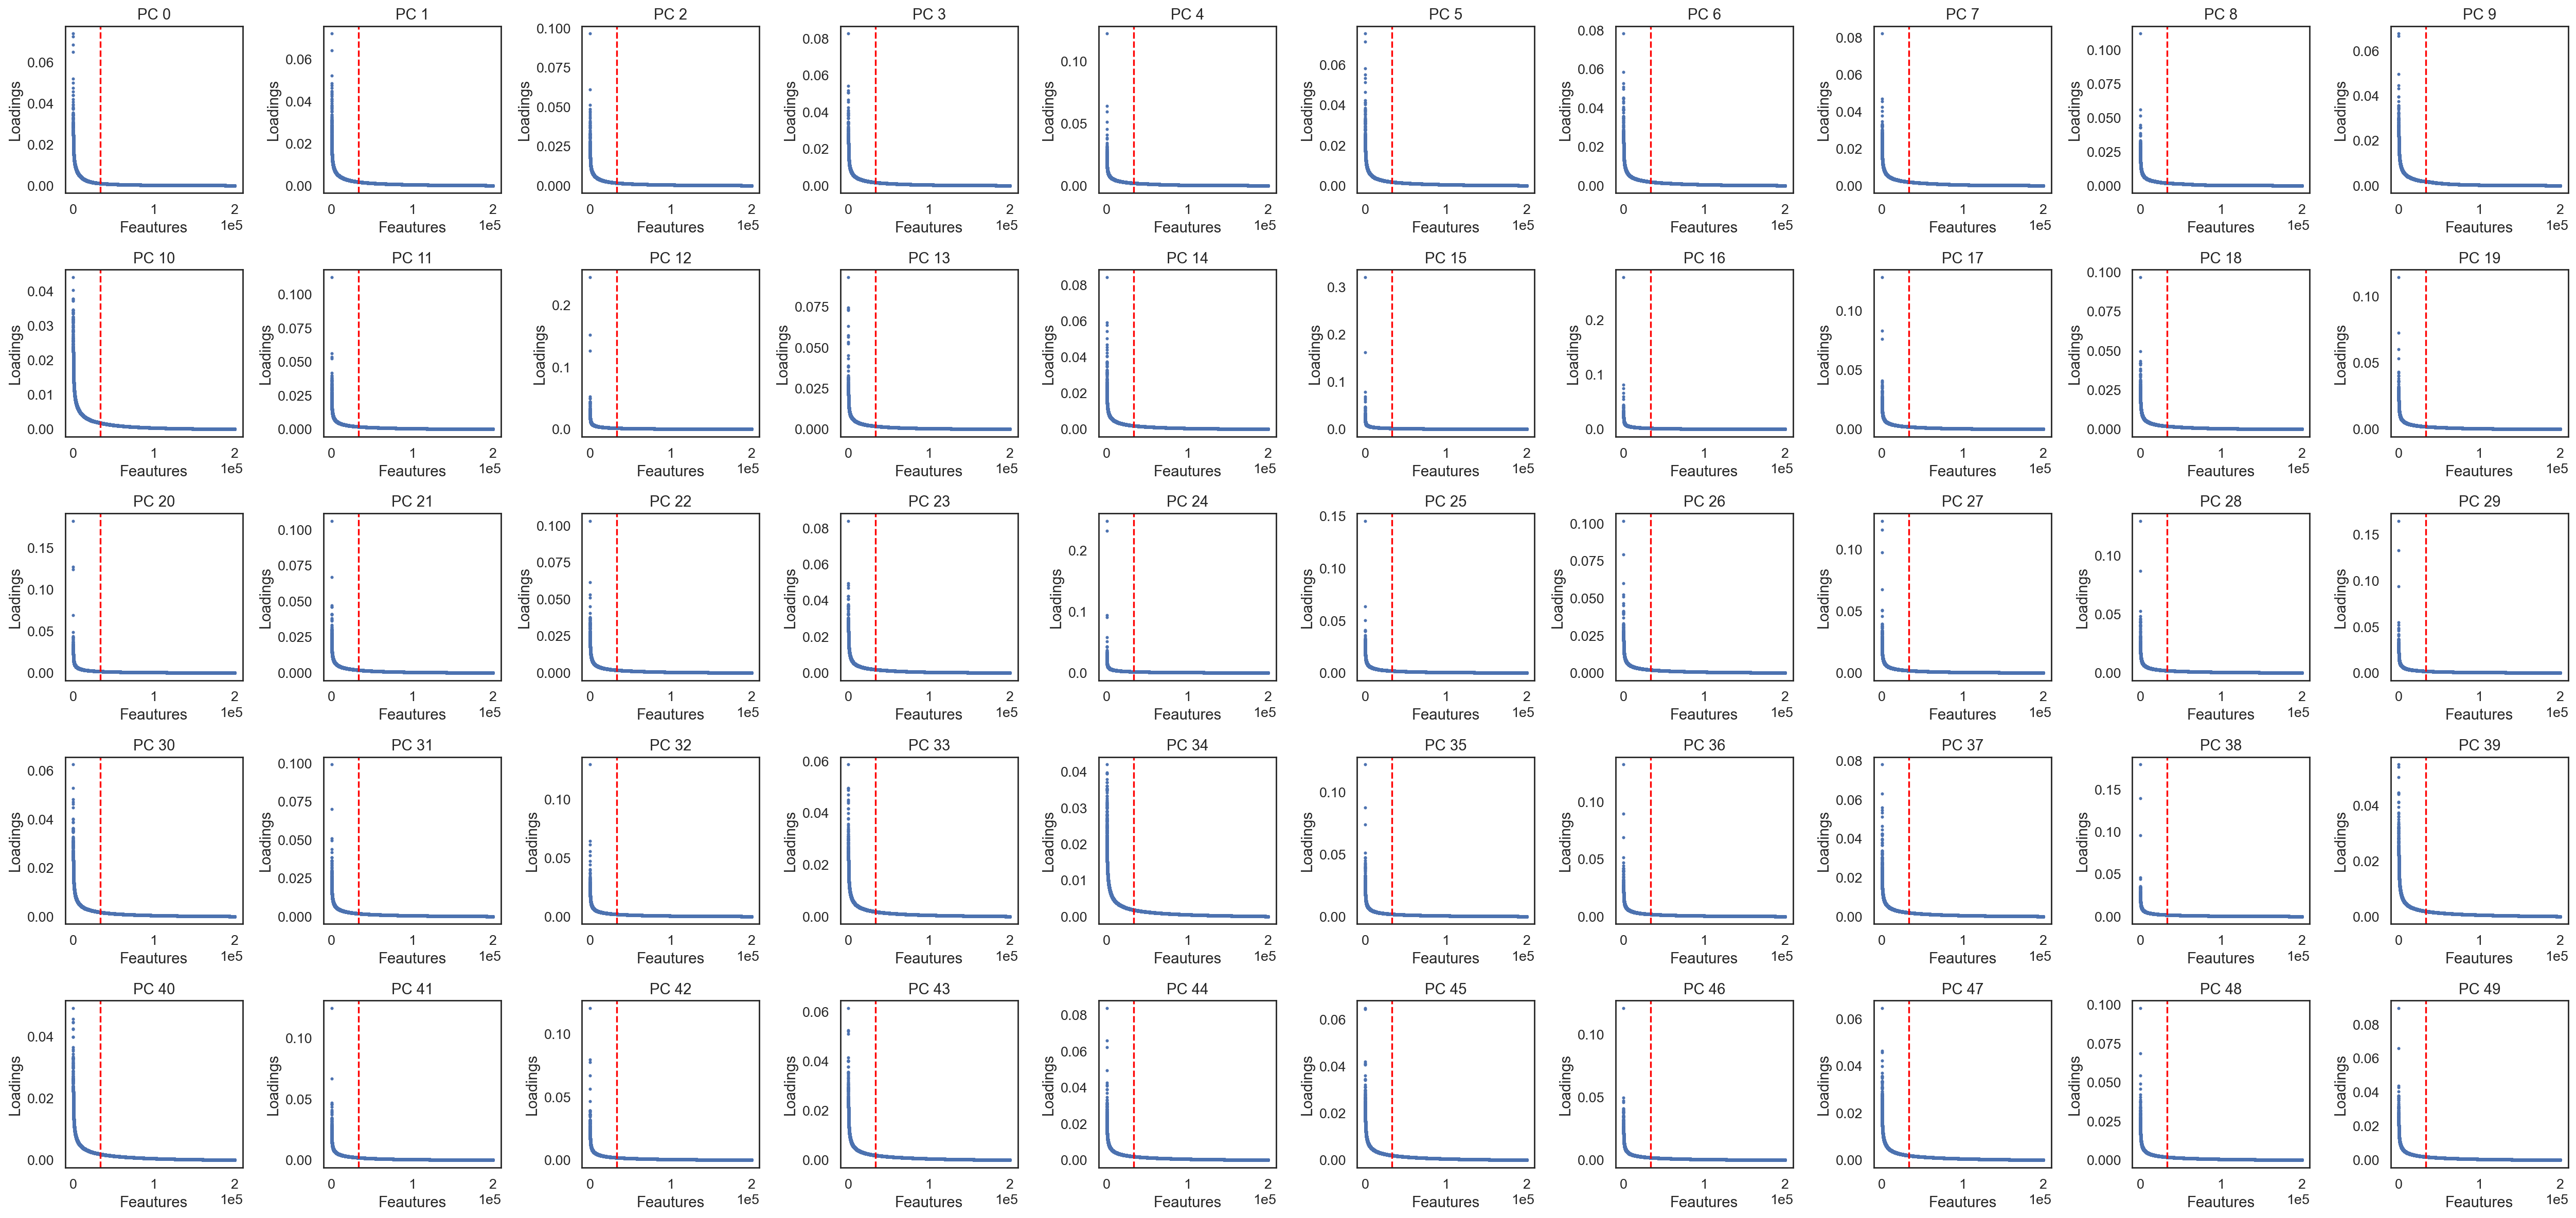

In [13]:
si.pl.pcs_features(adata_CP, fig_ncol=10)

### select DNA sequences (Optional) 

DNA sequences such as TF motifs or k-mers can be also encoded into the graph if needed.<br>

To scan peaks for kmers and motifs, first write the peak bed files.

In [14]:
si.write_bed(adata_CP, use_top_pcs=True)

"peaks.bed" was written to "result_simba_atacseq".


Then run the provided R script “[scan_for_kmers_motifs.R](https://raw.githubusercontent.com/pinellolab/simba/master/R_scripts/scan_for_kmers_motifs.R)” under the result directory (‘hg19.fa’ can be downloaded [here](https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz))

In [4]:
os.chdir(workdir)

In [5]:
#! curl https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz --output hg19.fa.gz
#! gunzip hg19.fa.gz
! curl https://raw.githubusercontent.com/pinellolab/simba/master/R_scripts/scan_for_kmers_motifs.R --output scan_for_kmers_motifs.R

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5767  100  5767    0     0  20539      0 --:--:-- --:--:-- --:--:-- 20596


> [Install the required packages](https://github.com/pinellolab/simba/blob/master/R_scripts/README.md) in your enviroment with the following command:
```bash
$ conda install r-essentials r-optparse bioconductor-jaspar2020 bioconductor-biostrings bioconductor-tfbstools bioconductor-motifmatchr bioconductor-summarizedexperiment r-doparallel bioconductor-rhdf5 bioconductor-hdf5array
```

In [18]:
%time
! Rscript scan_for_kmers_motifs.R -i peaks.bed -g hg19.fa -s 'Homo sapiens'

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 18.8 µs
Error in library(optparse, quietly = TRUE) : 
  there is no package called ‘optparse’
Calls: suppressMessages -> withCallingHandlers -> library
Execution halted


In [18]:
os.chdir("../")

In [17]:
1

1

In [19]:
adata_PK = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_kmer.h5'),'mat')
adata_PM = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_motif.h5'),'mat')

# convert byte string to string
adata_PK.obs.index = [x.decode('utf-8') for x in adata_PK.obs.index]
adata_PK.var.index = [x.decode('utf-8') for x in adata_PK.var.index]

adata_PM.obs.index = [x.decode('utf-8') for x in adata_PM.obs.index]
adata_PM.var.index = [x.decode('utf-8') for x in adata_PM.var.index]

In [20]:
adata_PK

AnnData object with n_obs × n_vars = 134535 × 4096

In [21]:
adata_PM

AnnData object with n_obs × n_vars = 134535 × 633

In [22]:
si.pp.binarize(adata_PK)
si.pp.binarize(adata_PM)

select kmers and motifs (optional)

In [23]:
si.pp.pca(adata_PK, n_components=50)
si.pp.pca(adata_PM, n_components=50)

In [24]:
si.pp.select_pcs_features(adata_PK, min_elbow=adata_PK.shape[1]/5, S=5)
si.pp.select_pcs_features(adata_PM, min_elbow=adata_PM.shape[1]/5, S=5)

#features selected from PC 0: 819
#features selected from PC 1: 828
#features selected from PC 2: 1491
#features selected from PC 3: 1495
#features selected from PC 4: 1981
#features selected from PC 5: 1710
#features selected from PC 6: 1277
#features selected from PC 7: 1877
#features selected from PC 8: 819
#features selected from PC 9: 1622
#features selected from PC 10: 1464
#features selected from PC 11: 1523
#features selected from PC 12: 1557
#features selected from PC 13: 1671
#features selected from PC 14: 1767
#features selected from PC 15: 1755
#features selected from PC 16: 2032
#features selected from PC 17: 1975
#features selected from PC 18: 819
#features selected from PC 19: 1843
#features selected from PC 20: 2072
#features selected from PC 21: 1766
#features selected from PC 22: 1711
#features selected from PC 23: 1861
#features selected from PC 24: 2002
#features selected from PC 25: 1891
#features selected from PC 26: 1820
#features selected from PC 27: 1886
#featu

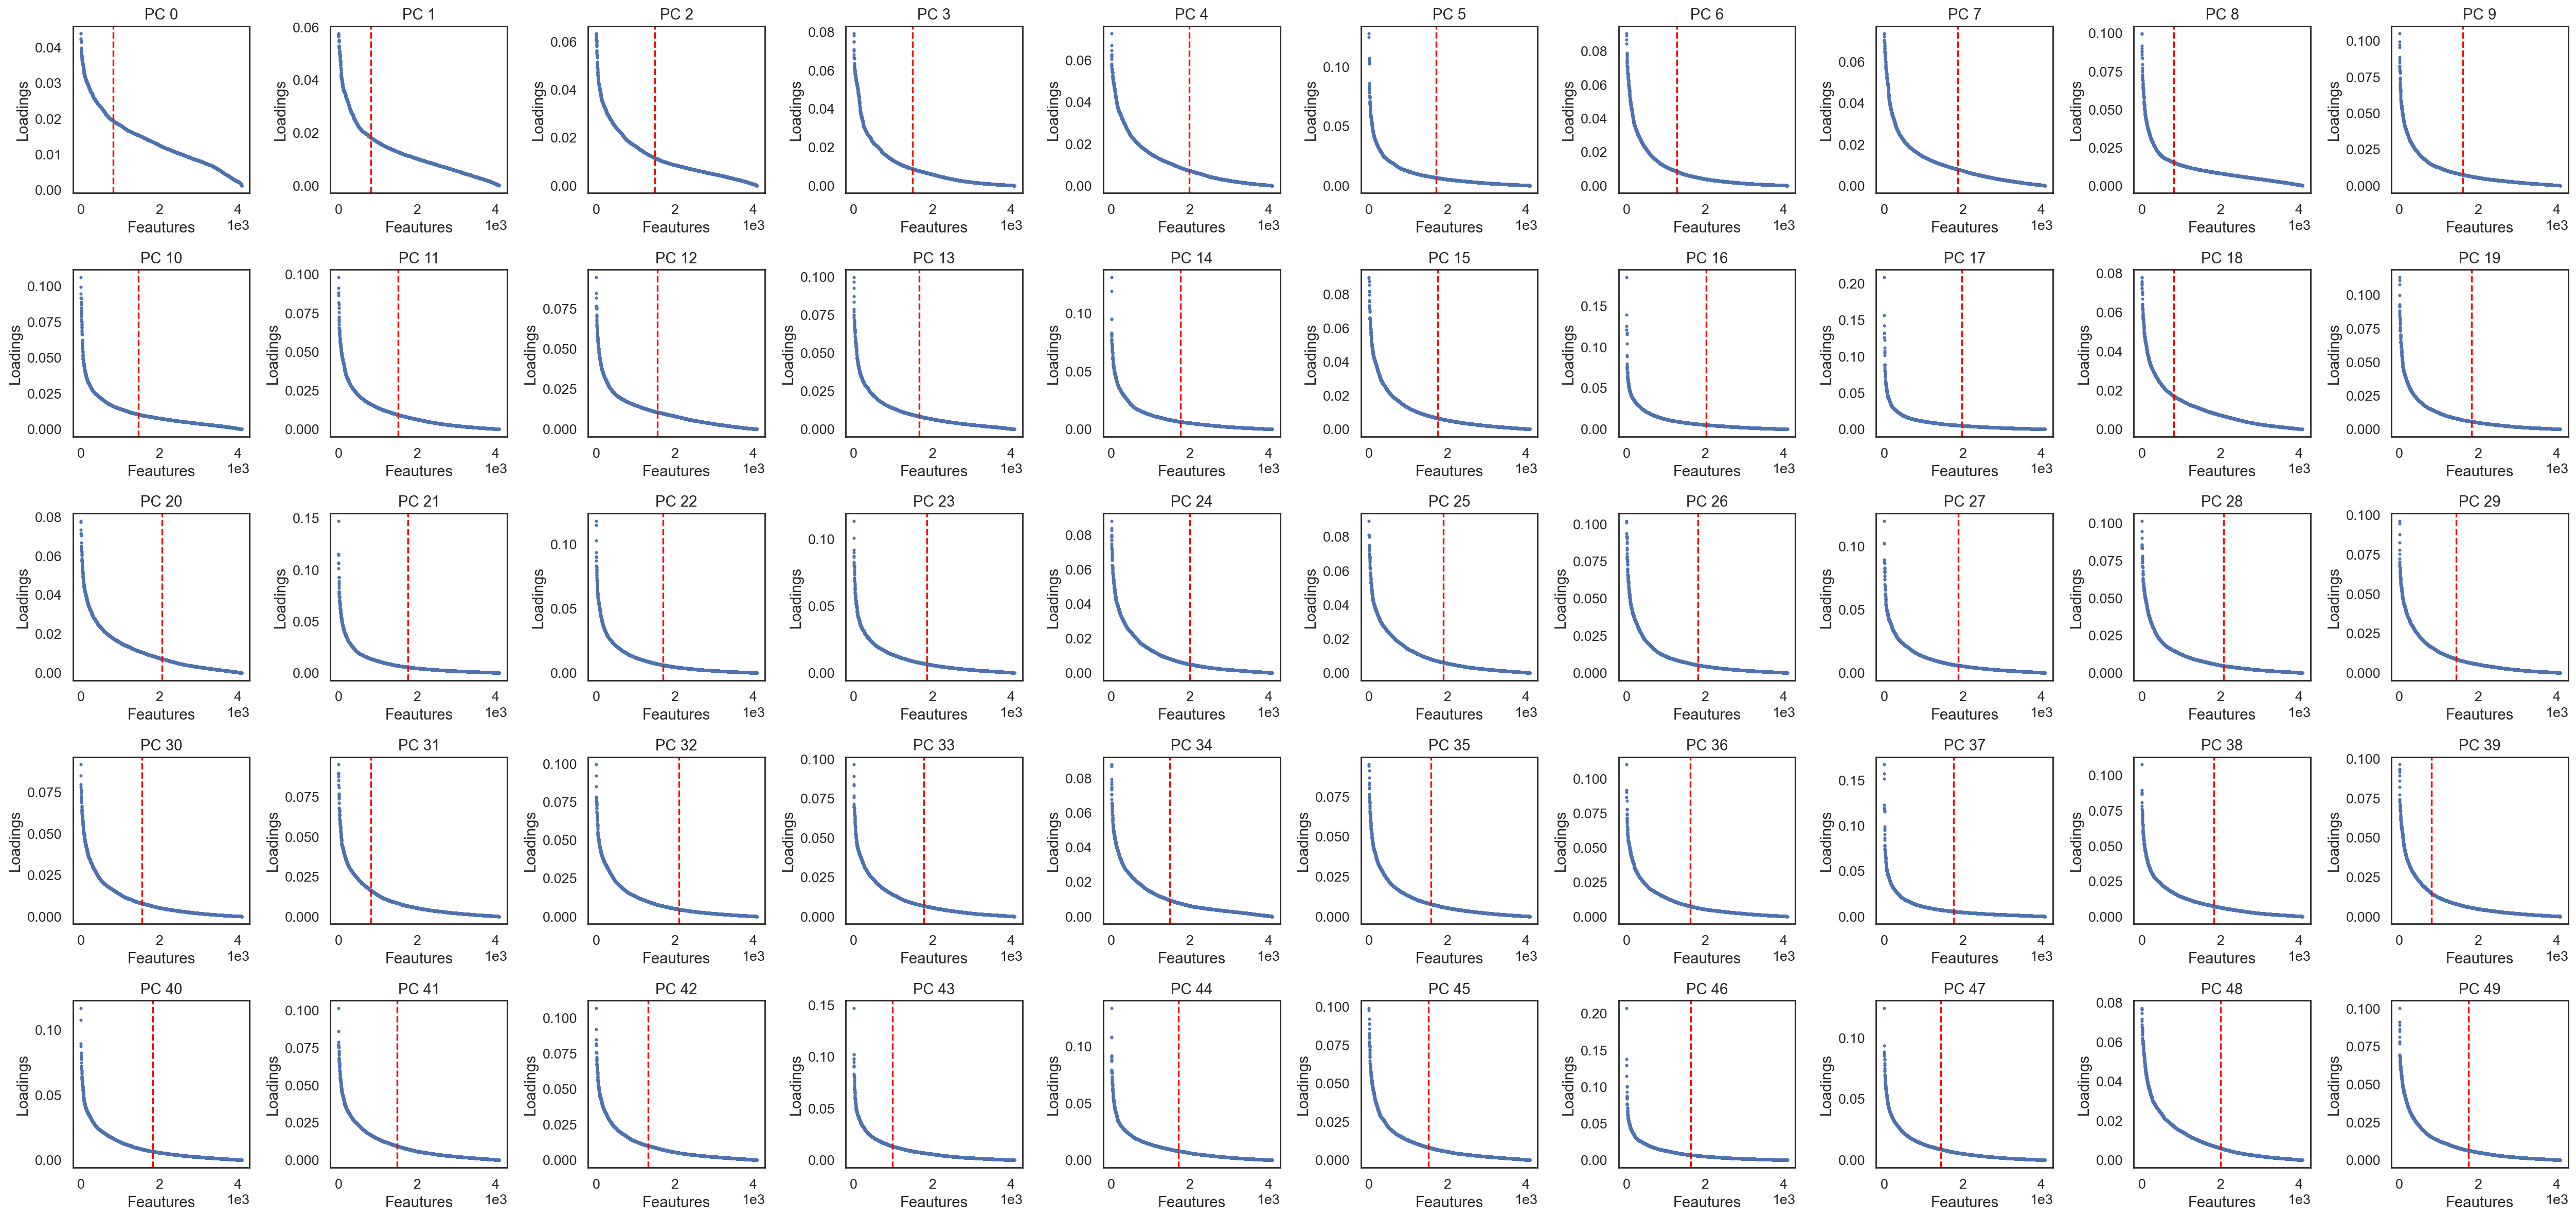

In [25]:
si.pl.pcs_features(adata_PK, fig_ncol=10)

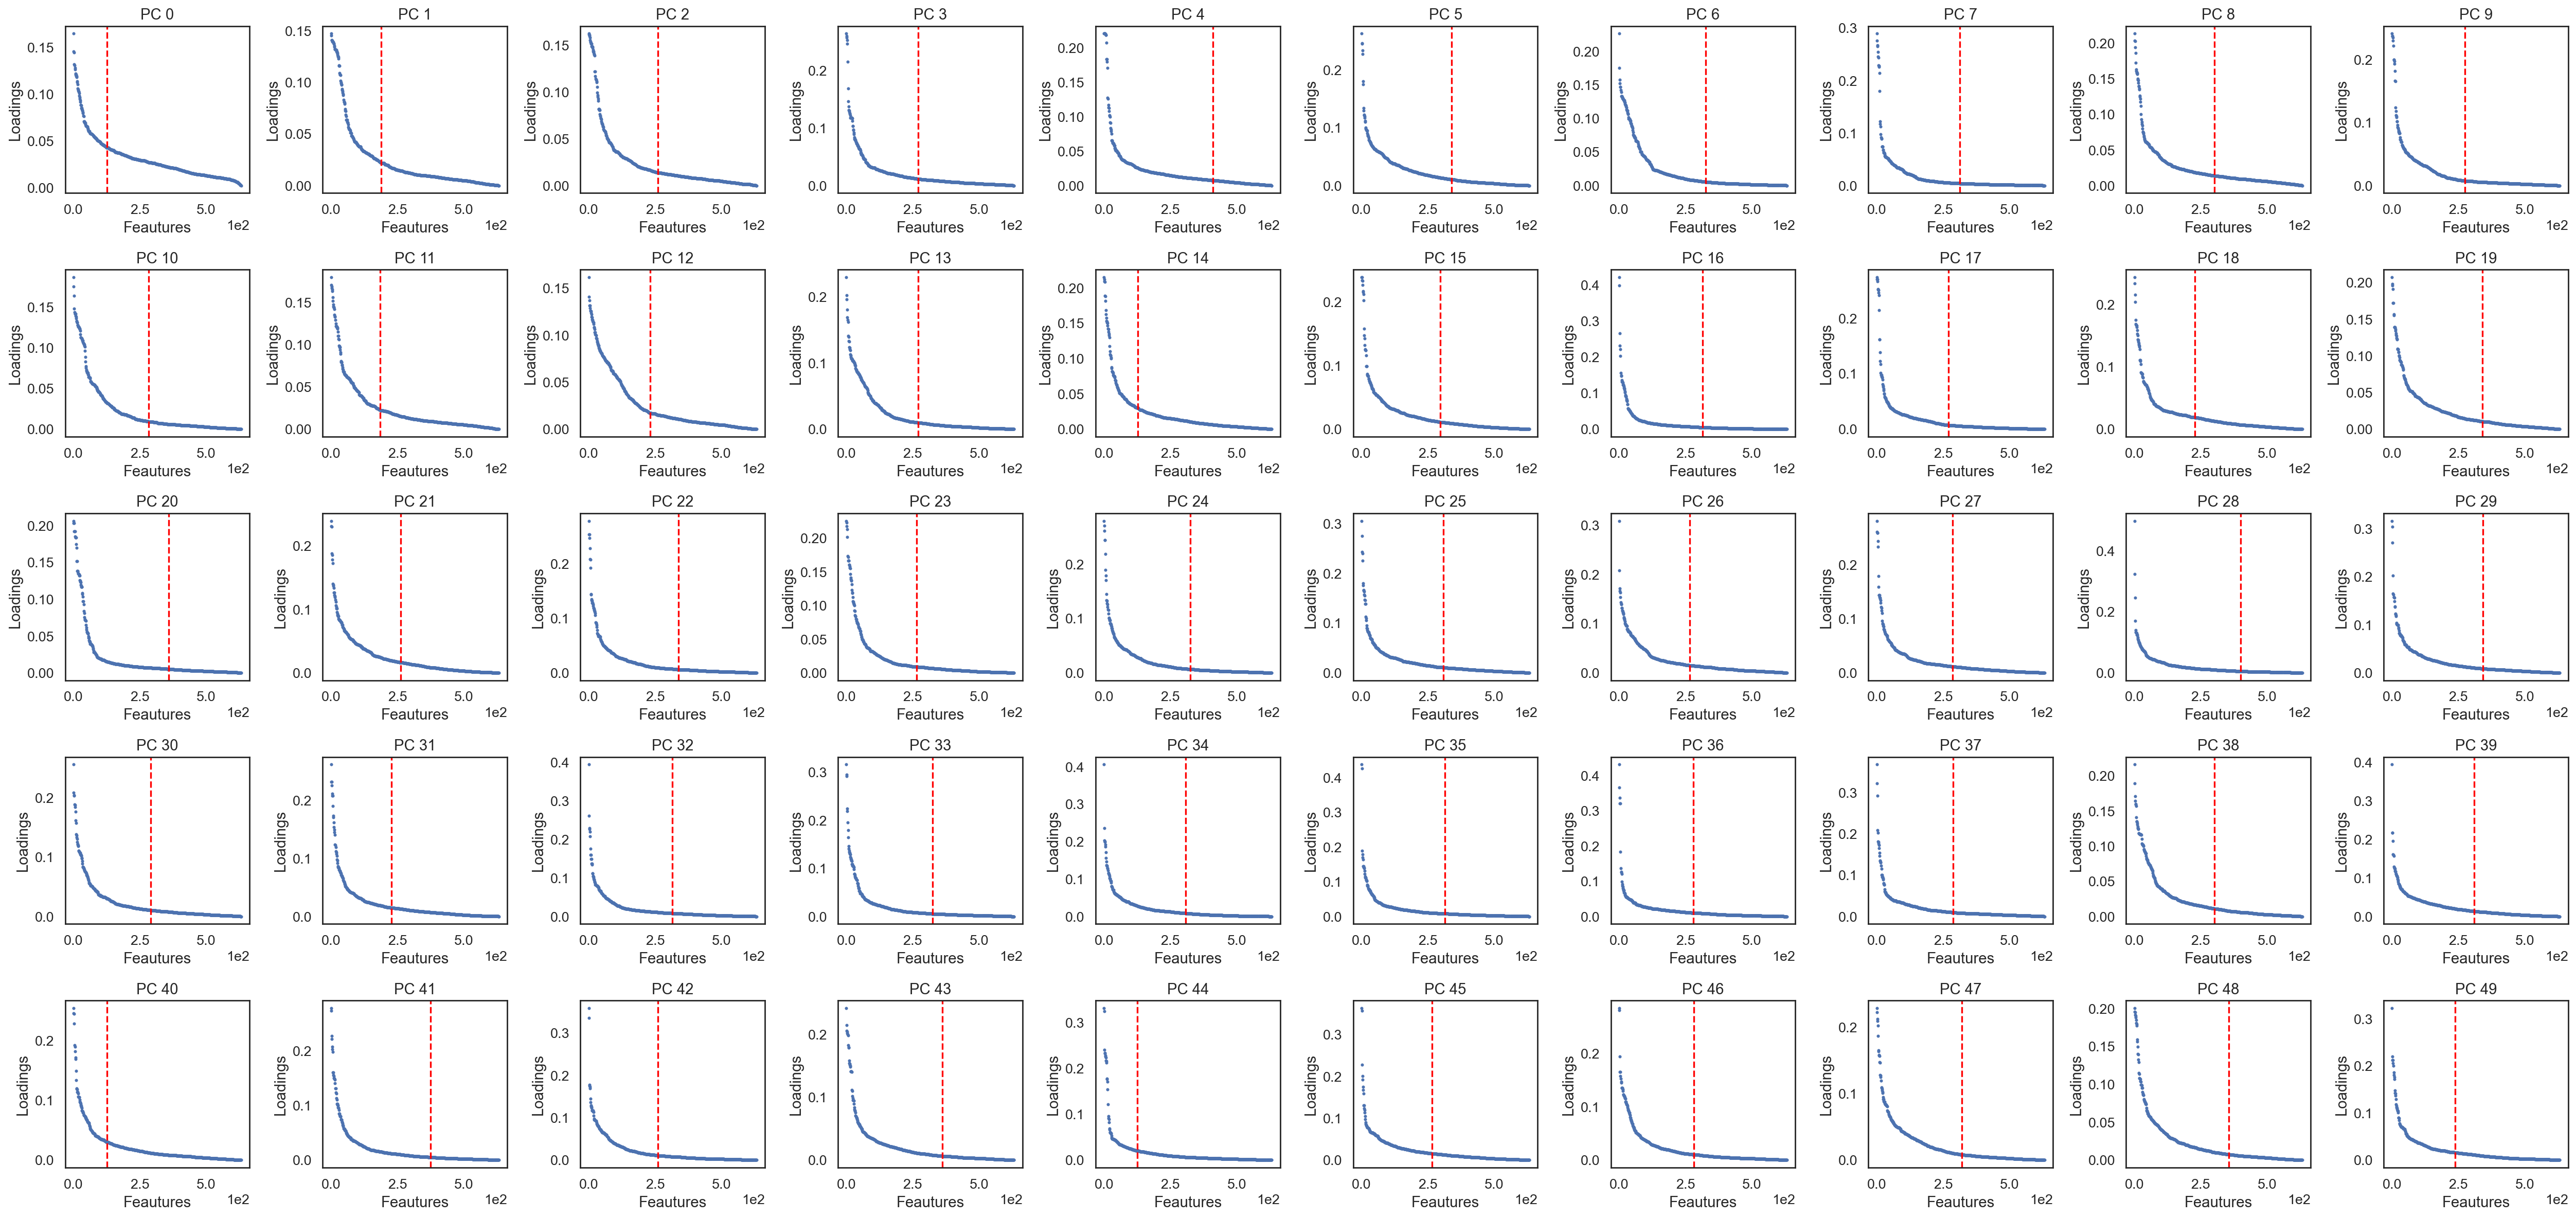

In [26]:
si.pl.pcs_features(adata_PM, fig_ncol=10)

### generate graph

In [27]:
si.tl.gen_graph(list_CP=[adata_CP],
                list_PK=[adata_PK],
                list_PM=[adata_PM],
                copy=False,
                use_top_pcs=True,
                dirname='graph_weight_fixed_5',
               get_marker_significance=True,
               fold_null_nodes=5.0)

`simba` does not exist in anndata 0 in `list_CP`.`.X` is being used instead.
relation0: source: C, destination: P
#edges: 12977763
`simba` does not exist in anndata 0 in `list_PM`.`.X` is being used instead.
relation1: source: P, destination: M
#edges: 5749259
`simba` does not exist in anndata 0 in `list_PK`.`.X` is being used instead.
relation2: source: P, destination: K
#edges: 57893992
Total number of edges: 76621014
Writing graph file "pbg_graph.txt" to "result_simba_atacseq/pbg/graph_weight_fixed_5" ...
Finished.
`simba` does not exist in anndata 0 in `list_CP`.`.X` is being used instead.
input graph: (2034, 134535)
relation0: source: C, destination: P
#edges: 12977763
relation1: source: nP, destination: C
#edges: 12977763
`simba` does not exist in anndata 0 in `list_PM`.`.X` is being used instead.
input graph: (134535, 601)
relation2: source: P, destination: M
#edges: 5749259
relation3: source: nM, destination: P
#edges: 28746295
`simba` does not exist in anndata 0 in `list_PK`.`

5-fold: 'graph_weight_fixed'

### PBG training

Before PBG training, let’s take a look at the parameters:

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change the number of cpus `workers`:

In [28]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.000309 
dict_config['workers'] = 12

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model_fixwd', get_marker_significance=True)

Auto-estimated weight decay is 3.085497E-04
`.settings.pbg_params['wd']` has been updated to 3.085497E-04
Converting input data ...
[2022-11-28 03:20:14.750484] Using the 3 relation types given in the config
[2022-11-28 03:20:14.751022] Searching for the entities in the edge files...
[2022-11-28 03:21:52.063406] Entity type C:
[2022-11-28 03:21:52.065014] - Found 2034 entities
[2022-11-28 03:21:52.065480] - Removing the ones with fewer than 1 occurrences...
[2022-11-28 03:21:52.066801] - Left with 2034 entities
[2022-11-28 03:21:52.067201] - Shuffling them...
[2022-11-28 03:21:52.068839] Entity type P:
[2022-11-28 03:21:52.069242] - Found 134535 entities
[2022-11-28 03:21:52.069596] - Removing the ones with fewer than 1 occurrences...
[2022-11-28 03:21:52.123759] - Left with 134535 entities
[2022-11-28 03:21:52.124397] - Shuffling them...
[2022-11-28 03:21:52.249252] Entity type K:
[2022-11-28 03:21:52.249944] - Found 3601 entities
[2022-11-28 03:21:52.250362] - Removing the ones with 

[2022-11-28 03:22:34.697325] - Processed 7900000 edges so far...
[2022-11-28 03:22:35.203772] - Processed 8000000 edges so far...
[2022-11-28 03:22:35.716283] - Processed 8100000 edges so far...
[2022-11-28 03:22:36.241870] - Processed 8200000 edges so far...
[2022-11-28 03:22:36.764759] - Processed 8300000 edges so far...
[2022-11-28 03:22:37.290165] - Processed 8400000 edges so far...
[2022-11-28 03:22:37.798087] - Processed 8500000 edges so far...
[2022-11-28 03:22:38.310408] - Processed 8600000 edges so far...
[2022-11-28 03:22:38.830095] - Processed 8700000 edges so far...
[2022-11-28 03:22:39.425367] - Processed 8800000 edges so far...
[2022-11-28 03:22:39.950091] - Processed 8900000 edges so far...
[2022-11-28 03:22:40.474370] - Processed 9000000 edges so far...
[2022-11-28 03:22:41.000627] - Processed 9100000 edges so far...
[2022-11-28 03:22:41.524136] - Processed 9200000 edges so far...
[2022-11-28 03:22:42.047911] - Processed 9300000 edges so far...
[2022-11-28 03:22:42.5643

[2022-11-28 03:23:35.816181] - Processed 20400000 edges so far...
[2022-11-28 03:23:36.290066] - Processed 20500000 edges so far...
[2022-11-28 03:23:36.765046] - Processed 20600000 edges so far...
[2022-11-28 03:23:37.256736] - Processed 20700000 edges so far...
[2022-11-28 03:23:37.748096] - Processed 20800000 edges so far...
[2022-11-28 03:23:38.235326] - Processed 20900000 edges so far...
[2022-11-28 03:23:38.722415] - Processed 21000000 edges so far...
[2022-11-28 03:23:39.208682] - Processed 21100000 edges so far...
[2022-11-28 03:23:39.697789] - Processed 21200000 edges so far...
[2022-11-28 03:23:40.185800] - Processed 21300000 edges so far...
[2022-11-28 03:23:40.673579] - Processed 21400000 edges so far...
[2022-11-28 03:23:41.160701] - Processed 21500000 edges so far...
[2022-11-28 03:23:41.641053] - Processed 21600000 edges so far...
[2022-11-28 03:23:42.115068] - Processed 21700000 edges so far...
[2022-11-28 03:23:42.591075] - Processed 21800000 edges so far...
[2022-11-2

[2022-11-28 03:24:36.203811] - Processed 32900000 edges so far...
[2022-11-28 03:24:36.685010] - Processed 33000000 edges so far...
[2022-11-28 03:24:37.170284] - Processed 33100000 edges so far...
[2022-11-28 03:24:37.650469] - Processed 33200000 edges so far...
[2022-11-28 03:24:38.132230] - Processed 33300000 edges so far...
[2022-11-28 03:24:38.620044] - Processed 33400000 edges so far...
[2022-11-28 03:24:39.112193] - Processed 33500000 edges so far...
[2022-11-28 03:24:39.598323] - Processed 33600000 edges so far...
[2022-11-28 03:24:40.087625] - Processed 33700000 edges so far...
[2022-11-28 03:24:40.572932] - Processed 33800000 edges so far...
[2022-11-28 03:24:41.064043] - Processed 33900000 edges so far...
[2022-11-28 03:24:41.554308] - Processed 34000000 edges so far...
[2022-11-28 03:24:42.041330] - Processed 34100000 edges so far...
[2022-11-28 03:24:42.529501] - Processed 34200000 edges so far...
[2022-11-28 03:24:43.014818] - Processed 34300000 edges so far...
[2022-11-2

[2022-11-28 03:25:36.857899] - Processed 45400000 edges so far...
[2022-11-28 03:25:37.346249] - Processed 45500000 edges so far...
[2022-11-28 03:25:37.840608] - Processed 45600000 edges so far...
[2022-11-28 03:25:38.332696] - Processed 45700000 edges so far...
[2022-11-28 03:25:38.824403] - Processed 45800000 edges so far...
[2022-11-28 03:25:39.310825] - Processed 45900000 edges so far...
[2022-11-28 03:25:39.797203] - Processed 46000000 edges so far...
[2022-11-28 03:25:40.303501] - Processed 46100000 edges so far...
[2022-11-28 03:25:40.816555] - Processed 46200000 edges so far...
[2022-11-28 03:25:41.303955] - Processed 46300000 edges so far...
[2022-11-28 03:25:41.792514] - Processed 46400000 edges so far...
[2022-11-28 03:25:42.284716] - Processed 46500000 edges so far...
[2022-11-28 03:25:42.775178] - Processed 46600000 edges so far...
[2022-11-28 03:25:43.258432] - Processed 46700000 edges so far...
[2022-11-28 03:25:43.738614] - Processed 46800000 edges so far...
[2022-11-2

[2022-11-28 03:26:39.134725] - Processed 57900000 edges so far...
[2022-11-28 03:26:39.631849] - Processed 58000000 edges so far...
[2022-11-28 03:26:40.127649] - Processed 58100000 edges so far...
[2022-11-28 03:26:40.642570] - Processed 58200000 edges so far...
[2022-11-28 03:26:41.135783] - Processed 58300000 edges so far...
[2022-11-28 03:26:41.625458] - Processed 58400000 edges so far...
[2022-11-28 03:26:42.120542] - Processed 58500000 edges so far...
[2022-11-28 03:26:42.650740] - Processed 58600000 edges so far...
[2022-11-28 03:26:43.169505] - Processed 58700000 edges so far...
[2022-11-28 03:26:43.686484] - Processed 58800000 edges so far...
[2022-11-28 03:26:44.212521] - Processed 58900000 edges so far...
[2022-11-28 03:26:44.733515] - Processed 59000000 edges so far...
[2022-11-28 03:26:45.252658] - Processed 59100000 edges so far...
[2022-11-28 03:26:45.779458] - Processed 59200000 edges so far...
[2022-11-28 03:26:46.304544] - Processed 59300000 edges so far...
[2022-11-2

[2022-11-28 03:27:43.068640] - Processed 70400000 edges so far...
[2022-11-28 03:27:43.612891] - Processed 70500000 edges so far...
[2022-11-28 03:27:44.135044] - Processed 70600000 edges so far...
[2022-11-28 03:27:44.661169] - Processed 70700000 edges so far...
[2022-11-28 03:27:45.192671] - Processed 70800000 edges so far...
[2022-11-28 03:27:45.683069] - Processed 70900000 edges so far...
[2022-11-28 03:27:46.192347] - Processed 71000000 edges so far...
[2022-11-28 03:27:46.685033] - Processed 71100000 edges so far...
[2022-11-28 03:27:47.197793] - Processed 71200000 edges so far...
[2022-11-28 03:27:47.693191] - Processed 71300000 edges so far...
[2022-11-28 03:27:48.189542] - Processed 71400000 edges so far...
[2022-11-28 03:27:48.693338] - Processed 71500000 edges so far...
[2022-11-28 03:27:49.181347] - Processed 71600000 edges so far...
[2022-11-28 03:27:49.697450] - Processed 71700000 edges so far...
[2022-11-28 03:27:50.187336] - Processed 71800000 edges so far...
[2022-11-2

[2022-11-28 04:01:52.506839] - Processed 1500000 edges so far...
[2022-11-28 04:01:53.043583] - Processed 1600000 edges so far...
[2022-11-28 04:01:53.574246] - Processed 1700000 edges so far...
[2022-11-28 04:01:54.111957] - Processed 1800000 edges so far...
[2022-11-28 04:01:54.641473] - Processed 1900000 edges so far...
[2022-11-28 04:01:55.163350] - Processed 2000000 edges so far...
[2022-11-28 04:01:55.695063] - Processed 2100000 edges so far...
[2022-11-28 04:01:56.231720] - Processed 2200000 edges so far...
[2022-11-28 04:01:56.765150] - Processed 2300000 edges so far...
[2022-11-28 04:01:57.296024] - Processed 2400000 edges so far...
[2022-11-28 04:01:57.819976] - Processed 2500000 edges so far...
[2022-11-28 04:01:58.356735] - Processed 2600000 edges so far...
[2022-11-28 04:01:58.906191] - Processed 2700000 edges so far...
[2022-11-28 04:01:59.455558] - Processed 2800000 edges so far...
[2022-11-28 04:01:59.985911] - Processed 2900000 edges so far...
[2022-11-28 04:02:00.5333

[2022-11-28 04:02:59.222105] - Processed 14100000 edges so far...
[2022-11-28 04:02:59.718141] - Processed 14200000 edges so far...
[2022-11-28 04:03:00.231944] - Processed 14300000 edges so far...
[2022-11-28 04:03:00.729862] - Processed 14400000 edges so far...
[2022-11-28 04:03:01.225193] - Processed 14500000 edges so far...
[2022-11-28 04:03:01.722118] - Processed 14600000 edges so far...
[2022-11-28 04:03:02.221379] - Processed 14700000 edges so far...
[2022-11-28 04:03:02.732092] - Processed 14800000 edges so far...
[2022-11-28 04:03:03.250635] - Processed 14900000 edges so far...
[2022-11-28 04:03:03.764395] - Processed 15000000 edges so far...
[2022-11-28 04:03:04.261727] - Processed 15100000 edges so far...
[2022-11-28 04:03:04.770850] - Processed 15200000 edges so far...
[2022-11-28 04:03:05.263736] - Processed 15300000 edges so far...
[2022-11-28 04:03:05.751869] - Processed 15400000 edges so far...
[2022-11-28 04:03:06.250711] - Processed 15500000 edges so far...
[2022-11-2

[2022-11-28 04:04:02.588213] - Processed 26600000 edges so far...
[2022-11-28 04:04:03.067929] - Processed 26700000 edges so far...
[2022-11-28 04:04:03.553061] - Processed 26800000 edges so far...
[2022-11-28 04:04:04.034192] - Processed 26900000 edges so far...
[2022-11-28 04:04:04.517542] - Processed 27000000 edges so far...
[2022-11-28 04:04:04.997747] - Processed 27100000 edges so far...
[2022-11-28 04:04:05.487837] - Processed 27200000 edges so far...
[2022-11-28 04:04:05.968354] - Processed 27300000 edges so far...
[2022-11-28 04:04:06.446974] - Processed 27400000 edges so far...
[2022-11-28 04:04:06.928505] - Processed 27500000 edges so far...
[2022-11-28 04:04:07.407521] - Processed 27600000 edges so far...
[2022-11-28 04:04:07.887299] - Processed 27700000 edges so far...
[2022-11-28 04:04:08.363410] - Processed 27800000 edges so far...
[2022-11-28 04:04:08.828727] - Processed 27900000 edges so far...
[2022-11-28 04:04:09.306554] - Processed 28000000 edges so far...
[2022-11-2

[2022-11-28 04:05:07.052182] - Processed 39100000 edges so far...
[2022-11-28 04:05:07.590589] - Processed 39200000 edges so far...
[2022-11-28 04:05:08.139156] - Processed 39300000 edges so far...
[2022-11-28 04:05:08.678726] - Processed 39400000 edges so far...
[2022-11-28 04:05:09.212950] - Processed 39500000 edges so far...
[2022-11-28 04:05:09.755259] - Processed 39600000 edges so far...
[2022-11-28 04:05:10.300495] - Processed 39700000 edges so far...
[2022-11-28 04:05:10.875318] - Processed 39800000 edges so far...
[2022-11-28 04:05:11.451909] - Processed 39900000 edges so far...
[2022-11-28 04:05:12.019972] - Processed 40000000 edges so far...
[2022-11-28 04:05:12.560379] - Processed 40100000 edges so far...
[2022-11-28 04:05:13.116785] - Processed 40200000 edges so far...
[2022-11-28 04:05:13.657811] - Processed 40300000 edges so far...
[2022-11-28 04:05:14.217602] - Processed 40400000 edges so far...
[2022-11-28 04:05:14.801832] - Processed 40500000 edges so far...
[2022-11-2

[2022-11-28 04:06:14.549229] - Processed 51600000 edges so far...
[2022-11-28 04:06:15.038092] - Processed 51700000 edges so far...
[2022-11-28 04:06:15.524392] - Processed 51800000 edges so far...
[2022-11-28 04:06:16.034902] - Processed 51900000 edges so far...
[2022-11-28 04:06:16.523650] - Processed 52000000 edges so far...
[2022-11-28 04:06:17.013984] - Processed 52100000 edges so far...
[2022-11-28 04:06:17.526058] - Processed 52200000 edges so far...
[2022-11-28 04:06:18.043452] - Processed 52300000 edges so far...
[2022-11-28 04:06:18.522625] - Processed 52400000 edges so far...
[2022-11-28 04:06:19.001480] - Processed 52500000 edges so far...
[2022-11-28 04:06:19.486682] - Processed 52600000 edges so far...
[2022-11-28 04:06:19.962299] - Processed 52700000 edges so far...
[2022-11-28 04:06:20.440253] - Processed 52800000 edges so far...
[2022-11-28 04:06:20.914102] - Processed 52900000 edges so far...
[2022-11-28 04:06:21.388886] - Processed 53000000 edges so far...
[2022-11-2

[2022-11-28 04:07:12.698419] - Processed 64100000 edges so far...
[2022-11-28 04:07:13.139286] - Processed 64200000 edges so far...
[2022-11-28 04:07:13.562493] - Processed 64300000 edges so far...
[2022-11-28 04:07:13.986386] - Processed 64400000 edges so far...
[2022-11-28 04:07:14.418511] - Processed 64500000 edges so far...
[2022-11-28 04:07:14.842207] - Processed 64600000 edges so far...
[2022-11-28 04:07:15.270283] - Processed 64700000 edges so far...
[2022-11-28 04:07:15.693471] - Processed 64800000 edges so far...
[2022-11-28 04:07:16.119507] - Processed 64900000 edges so far...
[2022-11-28 04:07:16.548290] - Processed 65000000 edges so far...
[2022-11-28 04:07:16.950062] - Processed 65100000 edges so far...
[2022-11-28 04:07:17.372496] - Processed 65200000 edges so far...
[2022-11-28 04:07:17.791165] - Processed 65300000 edges so far...
[2022-11-28 04:07:18.221022] - Processed 65400000 edges so far...
[2022-11-28 04:07:18.641428] - Processed 65500000 edges so far...
[2022-11-2

[2022-11-28 04:08:05.889310] - Processed 76600000 edges so far...
[2022-11-28 04:08:06.292056] - Processed 76700000 edges so far...
[2022-11-28 04:08:06.684575] - Processed 76800000 edges so far...
[2022-11-28 04:08:07.082728] - Processed 76900000 edges so far...
[2022-11-28 04:08:07.474491] - Processed 77000000 edges so far...
[2022-11-28 04:08:07.867683] - Processed 77100000 edges so far...
[2022-11-28 04:08:08.262864] - Processed 77200000 edges so far...
[2022-11-28 04:08:08.656761] - Processed 77300000 edges so far...
[2022-11-28 04:08:09.049711] - Processed 77400000 edges so far...
[2022-11-28 04:08:09.444062] - Processed 77500000 edges so far...
[2022-11-28 04:08:09.836746] - Processed 77600000 edges so far...
[2022-11-28 04:08:10.229832] - Processed 77700000 edges so far...
[2022-11-28 04:08:10.627993] - Processed 77800000 edges so far...
[2022-11-28 04:08:11.020622] - Processed 77900000 edges so far...
[2022-11-28 04:08:11.412713] - Processed 78000000 edges so far...
[2022-11-2

[2022-11-28 04:08:55.863414] - Processed 89100000 edges so far...
[2022-11-28 04:08:56.346412] - Processed 89200000 edges so far...
[2022-11-28 04:08:56.835624] - Processed 89300000 edges so far...
[2022-11-28 04:08:57.319217] - Processed 89400000 edges so far...
[2022-11-28 04:08:57.796708] - Processed 89500000 edges so far...
[2022-11-28 04:08:58.286734] - Processed 89600000 edges so far...
[2022-11-28 04:08:58.788273] - Processed 89700000 edges so far...
[2022-11-28 04:08:59.289452] - Processed 89800000 edges so far...
[2022-11-28 04:08:59.793557] - Processed 89900000 edges so far...
[2022-11-28 04:09:00.277115] - Processed 90000000 edges so far...
[2022-11-28 04:09:00.754590] - Processed 90100000 edges so far...
[2022-11-28 04:09:01.238041] - Processed 90200000 edges so far...
[2022-11-28 04:09:01.721866] - Processed 90300000 edges so far...
[2022-11-28 04:09:02.203623] - Processed 90400000 edges so far...
[2022-11-28 04:09:02.684795] - Processed 90500000 edges so far...
[2022-11-2

[2022-11-28 04:09:57.978069] - Processed 101500000 edges so far...
[2022-11-28 04:09:58.486999] - Processed 101600000 edges so far...
[2022-11-28 04:09:58.994607] - Processed 101700000 edges so far...
[2022-11-28 04:09:59.492120] - Processed 101800000 edges so far...
[2022-11-28 04:10:00.000963] - Processed 101900000 edges so far...
[2022-11-28 04:10:00.496149] - Processed 102000000 edges so far...
[2022-11-28 04:10:00.995368] - Processed 102100000 edges so far...
[2022-11-28 04:10:01.511994] - Processed 102200000 edges so far...
[2022-11-28 04:10:02.009156] - Processed 102300000 edges so far...
[2022-11-28 04:10:02.508024] - Processed 102400000 edges so far...
[2022-11-28 04:10:03.022238] - Processed 102500000 edges so far...
[2022-11-28 04:10:03.518198] - Processed 102600000 edges so far...
[2022-11-28 04:10:04.013164] - Processed 102700000 edges so far...
[2022-11-28 04:10:04.519962] - Processed 102800000 edges so far...
[2022-11-28 04:10:05.041423] - Processed 102900000 edges so fa

[2022-11-28 04:11:00.417747] - Processed 113800000 edges so far...
[2022-11-28 04:11:00.924413] - Processed 113900000 edges so far...
[2022-11-28 04:11:01.427925] - Processed 114000000 edges so far...
[2022-11-28 04:11:01.971183] - Processed 114100000 edges so far...
[2022-11-28 04:11:02.478484] - Processed 114200000 edges so far...
[2022-11-28 04:11:02.966858] - Processed 114300000 edges so far...
[2022-11-28 04:11:03.478889] - Processed 114400000 edges so far...
[2022-11-28 04:11:03.970346] - Processed 114500000 edges so far...
[2022-11-28 04:11:04.467032] - Processed 114600000 edges so far...
[2022-11-28 04:11:04.968091] - Processed 114700000 edges so far...
[2022-11-28 04:11:05.464167] - Processed 114800000 edges so far...
[2022-11-28 04:11:05.953220] - Processed 114900000 edges so far...
[2022-11-28 04:11:06.437619] - Processed 115000000 edges so far...
[2022-11-28 04:11:06.930411] - Processed 115100000 edges so far...
[2022-11-28 04:11:07.426788] - Processed 115200000 edges so fa

[2022-11-28 04:12:05.228017] - Processed 126100000 edges so far...
[2022-11-28 04:12:05.798870] - Processed 126200000 edges so far...
[2022-11-28 04:12:06.335122] - Processed 126300000 edges so far...
[2022-11-28 04:12:06.911891] - Processed 126400000 edges so far...
[2022-11-28 04:12:07.470262] - Processed 126500000 edges so far...
[2022-11-28 04:12:08.014792] - Processed 126600000 edges so far...
[2022-11-28 04:12:08.559286] - Processed 126700000 edges so far...
[2022-11-28 04:12:09.099201] - Processed 126800000 edges so far...
[2022-11-28 04:12:09.639651] - Processed 126900000 edges so far...
[2022-11-28 04:12:10.222802] - Processed 127000000 edges so far...
[2022-11-28 04:12:10.775188] - Processed 127100000 edges so far...
[2022-11-28 04:12:11.322087] - Processed 127200000 edges so far...
[2022-11-28 04:12:11.880695] - Processed 127300000 edges so far...
[2022-11-28 04:12:12.414195] - Processed 127400000 edges so far...
[2022-11-28 04:12:12.953533] - Processed 127500000 edges so fa

[2022-11-28 04:13:13.106975] - Processed 138400000 edges so far...
[2022-11-28 04:13:13.637311] - Processed 138500000 edges so far...
[2022-11-28 04:13:14.161821] - Processed 138600000 edges so far...
[2022-11-28 04:13:14.709223] - Processed 138700000 edges so far...
[2022-11-28 04:13:15.253751] - Processed 138800000 edges so far...
[2022-11-28 04:13:15.802984] - Processed 138900000 edges so far...
[2022-11-28 04:13:16.342023] - Processed 139000000 edges so far...
[2022-11-28 04:13:16.902431] - Processed 139100000 edges so far...
[2022-11-28 04:13:17.429730] - Processed 139200000 edges so far...
[2022-11-28 04:13:17.964087] - Processed 139300000 edges so far...
[2022-11-28 04:13:18.509416] - Processed 139400000 edges so far...
[2022-11-28 04:13:19.034674] - Processed 139500000 edges so far...
[2022-11-28 04:13:19.568200] - Processed 139600000 edges so far...
[2022-11-28 04:13:20.103323] - Processed 139700000 edges so far...
[2022-11-28 04:13:20.651768] - Processed 139800000 edges so fa

[2022-11-28 04:14:20.634744] - Processed 150700000 edges so far...
[2022-11-28 04:14:21.220591] - Processed 150800000 edges so far...
[2022-11-28 04:14:21.775376] - Processed 150900000 edges so far...
[2022-11-28 04:14:22.326557] - Processed 151000000 edges so far...
[2022-11-28 04:14:22.875949] - Processed 151100000 edges so far...
[2022-11-28 04:14:23.442271] - Processed 151200000 edges so far...
[2022-11-28 04:14:24.018010] - Processed 151300000 edges so far...
[2022-11-28 04:14:24.605528] - Processed 151400000 edges so far...
[2022-11-28 04:14:25.169692] - Processed 151500000 edges so far...
[2022-11-28 04:14:25.740953] - Processed 151600000 edges so far...
[2022-11-28 04:14:26.312787] - Processed 151700000 edges so far...
[2022-11-28 04:14:26.869239] - Processed 151800000 edges so far...
[2022-11-28 04:14:27.429769] - Processed 151900000 edges so far...
[2022-11-28 04:14:27.990168] - Processed 152000000 edges so far...
[2022-11-28 04:14:28.560164] - Processed 152100000 edges so fa

[2022-11-28 04:15:29.095911] - Processed 163000000 edges so far...
[2022-11-28 04:15:29.646295] - Processed 163100000 edges so far...
[2022-11-28 04:15:30.229233] - Processed 163200000 edges so far...
[2022-11-28 04:15:30.782258] - Processed 163300000 edges so far...
[2022-11-28 04:15:31.357101] - Processed 163400000 edges so far...
[2022-11-28 04:15:31.897922] - Processed 163500000 edges so far...
[2022-11-28 04:15:32.469466] - Processed 163600000 edges so far...
[2022-11-28 04:15:33.037131] - Processed 163700000 edges so far...
[2022-11-28 04:15:33.616431] - Processed 163800000 edges so far...
[2022-11-28 04:15:34.166213] - Processed 163900000 edges so far...
[2022-11-28 04:15:34.721803] - Processed 164000000 edges so far...
[2022-11-28 04:15:35.305277] - Processed 164100000 edges so far...
[2022-11-28 04:15:35.850822] - Processed 164200000 edges so far...
[2022-11-28 04:15:36.420111] - Processed 164300000 edges so far...
[2022-11-28 04:15:36.974027] - Processed 164400000 edges so fa

[2022-11-28 04:16:38.165874] - Processed 175300000 edges so far...
[2022-11-28 04:16:38.731997] - Processed 175400000 edges so far...
[2022-11-28 04:16:39.309408] - Processed 175500000 edges so far...
[2022-11-28 04:16:39.853527] - Processed 175600000 edges so far...
[2022-11-28 04:16:40.420044] - Processed 175700000 edges so far...
[2022-11-28 04:16:40.967105] - Processed 175800000 edges so far...
[2022-11-28 04:16:41.530960] - Processed 175900000 edges so far...
[2022-11-28 04:16:42.100031] - Processed 176000000 edges so far...
[2022-11-28 04:16:42.652033] - Processed 176100000 edges so far...
[2022-11-28 04:16:43.199958] - Processed 176200000 edges so far...
[2022-11-28 04:16:43.763821] - Processed 176300000 edges so far...
[2022-11-28 04:16:44.328704] - Processed 176400000 edges so far...
[2022-11-28 04:16:44.878726] - Processed 176500000 edges so far...
[2022-11-28 04:16:45.442765] - Processed 176600000 edges so far...
[2022-11-28 04:16:45.989179] - Processed 176700000 edges so fa

[2022-11-28 04:17:46.546798] - Processed 187600000 edges so far...
[2022-11-28 04:17:47.101827] - Processed 187700000 edges so far...
[2022-11-28 04:17:47.679049] - Processed 187800000 edges so far...
[2022-11-28 04:17:48.237960] - Processed 187900000 edges so far...
[2022-11-28 04:17:48.789646] - Processed 188000000 edges so far...
[2022-11-28 04:17:49.352347] - Processed 188100000 edges so far...
[2022-11-28 04:17:49.920090] - Processed 188200000 edges so far...
[2022-11-28 04:17:50.488854] - Processed 188300000 edges so far...
[2022-11-28 04:17:51.035342] - Processed 188400000 edges so far...
[2022-11-28 04:17:51.592165] - Processed 188500000 edges so far...
[2022-11-28 04:17:52.141990] - Processed 188600000 edges so far...
[2022-11-28 04:17:52.706634] - Processed 188700000 edges so far...
[2022-11-28 04:17:53.254544] - Processed 188800000 edges so far...
[2022-11-28 04:17:53.819945] - Processed 188900000 edges so far...
[2022-11-28 04:17:54.367716] - Processed 189000000 edges so fa

[2022-11-28 04:18:54.107496] - Processed 199900000 edges so far...
[2022-11-28 04:18:54.653734] - Processed 200000000 edges so far...
[2022-11-28 04:18:55.180977] - Processed 200100000 edges so far...
[2022-11-28 04:18:55.707639] - Processed 200200000 edges so far...
[2022-11-28 04:18:56.236681] - Processed 200300000 edges so far...
[2022-11-28 04:18:56.762605] - Processed 200400000 edges so far...
[2022-11-28 04:18:57.287275] - Processed 200500000 edges so far...
[2022-11-28 04:18:57.807386] - Processed 200600000 edges so far...
[2022-11-28 04:18:58.320510] - Processed 200700000 edges so far...
[2022-11-28 04:18:58.840809] - Processed 200800000 edges so far...
[2022-11-28 04:18:59.367868] - Processed 200900000 edges so far...
[2022-11-28 04:18:59.916556] - Processed 201000000 edges so far...
[2022-11-28 04:19:00.443134] - Processed 201100000 edges so far...
[2022-11-28 04:19:00.969714] - Processed 201200000 edges so far...
[2022-11-28 04:19:01.513055] - Processed 201300000 edges so fa

[2022-11-28 04:20:00.726154] - Processed 212200000 edges so far...
[2022-11-28 04:20:01.252360] - Processed 212300000 edges so far...
[2022-11-28 04:20:01.783140] - Processed 212400000 edges so far...
[2022-11-28 04:20:02.306919] - Processed 212500000 edges so far...
[2022-11-28 04:20:02.829015] - Processed 212600000 edges so far...
[2022-11-28 04:20:03.354473] - Processed 212700000 edges so far...
[2022-11-28 04:20:03.891678] - Processed 212800000 edges so far...
[2022-11-28 04:20:04.408758] - Processed 212900000 edges so far...
[2022-11-28 04:20:04.926449] - Processed 213000000 edges so far...
[2022-11-28 04:20:05.453930] - Processed 213100000 edges so far...
[2022-11-28 04:20:05.973018] - Processed 213200000 edges so far...
[2022-11-28 04:20:06.497365] - Processed 213300000 edges so far...
[2022-11-28 04:20:07.015596] - Processed 213400000 edges so far...
[2022-11-28 04:20:07.532733] - Processed 213500000 edges so far...
[2022-11-28 04:20:08.055641] - Processed 213600000 edges so fa

[2022-11-28 04:21:02.603308] - Processed 224500000 edges so far...
[2022-11-28 04:21:03.021382] - Processed 224600000 edges so far...
[2022-11-28 04:21:03.439050] - Processed 224700000 edges so far...
[2022-11-28 04:21:03.892054] - Processed 224800000 edges so far...
[2022-11-28 04:21:04.330808] - Processed 224900000 edges so far...
[2022-11-28 04:21:04.784700] - Processed 225000000 edges so far...
[2022-11-28 04:21:05.223938] - Processed 225100000 edges so far...
[2022-11-28 04:21:05.671531] - Processed 225200000 edges so far...
[2022-11-28 04:21:06.105372] - Processed 225300000 edges so far...
[2022-11-28 04:21:06.543693] - Processed 225400000 edges so far...
[2022-11-28 04:21:07.003449] - Processed 225500000 edges so far...
[2022-11-28 04:21:07.454038] - Processed 225600000 edges so far...
[2022-11-28 04:21:07.878533] - Processed 225700000 edges so far...
[2022-11-28 04:21:08.301341] - Processed 225800000 edges so far...
[2022-11-28 04:21:08.723527] - Processed 225900000 edges so fa

[2022-11-28 04:22:00.988919] - Processed 236800000 edges so far...
[2022-11-28 04:22:01.498783] - Processed 236900000 edges so far...
[2022-11-28 04:22:02.041492] - Processed 237000000 edges so far...
[2022-11-28 04:22:02.583939] - Processed 237100000 edges so far...
[2022-11-28 04:22:03.108934] - Processed 237200000 edges so far...
[2022-11-28 04:22:03.646798] - Processed 237300000 edges so far...
[2022-11-28 04:22:04.205939] - Processed 237400000 edges so far...
[2022-11-28 04:22:04.772621] - Processed 237500000 edges so far...
[2022-11-28 04:22:05.239362] - Processed 237600000 edges so far...
[2022-11-28 04:22:05.689498] - Processed 237700000 edges so far...
[2022-11-28 04:22:06.118062] - Processed 237800000 edges so far...
[2022-11-28 04:22:06.524625] - Processed 237900000 edges so far...
[2022-11-28 04:22:06.947334] - Processed 238000000 edges so far...
[2022-11-28 04:22:07.360296] - Processed 238100000 edges so far...
[2022-11-28 04:22:07.778386] - Processed 238200000 edges so fa

[2022-11-28 04:22:52.647332] - Processed 249100000 edges so far...
[2022-11-28 04:22:53.065528] - Processed 249200000 edges so far...
[2022-11-28 04:22:53.469875] - Processed 249300000 edges so far...
[2022-11-28 04:22:53.891834] - Processed 249400000 edges so far...
[2022-11-28 04:22:54.295273] - Processed 249500000 edges so far...
[2022-11-28 04:22:54.700579] - Processed 249600000 edges so far...
[2022-11-28 04:22:55.106849] - Processed 249700000 edges so far...
[2022-11-28 04:22:55.510547] - Processed 249800000 edges so far...
[2022-11-28 04:22:55.915566] - Processed 249900000 edges so far...
[2022-11-28 04:22:56.320131] - Processed 250000000 edges so far...
[2022-11-28 04:22:56.722209] - Processed 250100000 edges so far...
[2022-11-28 04:22:57.126193] - Processed 250200000 edges so far...
[2022-11-28 04:22:57.548410] - Processed 250300000 edges so far...
[2022-11-28 04:22:57.952078] - Processed 250400000 edges so far...
[2022-11-28 04:22:58.373111] - Processed 250500000 edges so fa

[2022-11-28 04:23:51.447717] - Processed 261400000 edges so far...
[2022-11-28 04:23:51.992697] - Processed 261500000 edges so far...
[2022-11-28 04:23:52.533105] - Processed 261600000 edges so far...
[2022-11-28 04:23:53.074154] - Processed 261700000 edges so far...
[2022-11-28 04:23:53.622055] - Processed 261800000 edges so far...
[2022-11-28 04:23:54.159924] - Processed 261900000 edges so far...
[2022-11-28 04:23:54.681595] - Processed 262000000 edges so far...
[2022-11-28 04:23:55.210021] - Processed 262100000 edges so far...
[2022-11-28 04:23:55.728436] - Processed 262200000 edges so far...
[2022-11-28 04:23:56.274817] - Processed 262300000 edges so far...
[2022-11-28 04:23:56.819333] - Processed 262400000 edges so far...
[2022-11-28 04:23:57.350724] - Processed 262500000 edges so far...
[2022-11-28 04:23:57.901300] - Processed 262600000 edges so far...
[2022-11-28 04:23:58.453254] - Processed 262700000 edges so far...
[2022-11-28 04:23:58.971688] - Processed 262800000 edges so fa

[2022-11-28 04:24:57.287493] - Processed 273700000 edges so far...
[2022-11-28 04:24:57.806627] - Processed 273800000 edges so far...
[2022-11-28 04:24:58.353472] - Processed 273900000 edges so far...
[2022-11-28 04:24:58.876299] - Processed 274000000 edges so far...
[2022-11-28 04:24:59.409575] - Processed 274100000 edges so far...
[2022-11-28 04:24:59.923960] - Processed 274200000 edges so far...
[2022-11-28 04:25:00.449473] - Processed 274300000 edges so far...
[2022-11-28 04:25:00.976021] - Processed 274400000 edges so far...
[2022-11-28 04:25:01.501554] - Processed 274500000 edges so far...
[2022-11-28 04:25:02.044894] - Processed 274600000 edges so far...
[2022-11-28 04:25:02.574989] - Processed 274700000 edges so far...
[2022-11-28 04:25:03.115688] - Processed 274800000 edges so far...
[2022-11-28 04:25:03.652789] - Processed 274900000 edges so far...
[2022-11-28 04:25:04.209023] - Processed 275000000 edges so far...
[2022-11-28 04:25:04.745647] - Processed 275100000 edges so fa

[2022-11-28 04:26:02.899883] - Processed 286000000 edges so far...
[2022-11-28 04:26:03.428117] - Processed 286100000 edges so far...
[2022-11-28 04:26:03.977185] - Processed 286200000 edges so far...
[2022-11-28 04:26:04.500825] - Processed 286300000 edges so far...
[2022-11-28 04:26:05.044532] - Processed 286400000 edges so far...
[2022-11-28 04:26:05.585268] - Processed 286500000 edges so far...
[2022-11-28 04:26:06.110251] - Processed 286600000 edges so far...
[2022-11-28 04:26:06.641588] - Processed 286700000 edges so far...
[2022-11-28 04:26:07.169095] - Processed 286800000 edges so far...
[2022-11-28 04:26:07.687383] - Processed 286900000 edges so far...
[2022-11-28 04:26:08.216304] - Processed 287000000 edges so far...
[2022-11-28 04:26:08.746892] - Processed 287100000 edges so far...
[2022-11-28 04:26:09.292112] - Processed 287200000 edges so far...
[2022-11-28 04:26:09.819301] - Processed 287300000 edges so far...
[2022-11-28 04:26:10.362102] - Processed 287400000 edges so fa

[2022-11-28 04:27:08.439737] - Processed 298300000 edges so far...
[2022-11-28 04:27:08.989446] - Processed 298400000 edges so far...
[2022-11-28 04:27:09.514872] - Processed 298500000 edges so far...
[2022-11-28 04:27:10.060129] - Processed 298600000 edges so far...
[2022-11-28 04:27:10.586194] - Processed 298700000 edges so far...
[2022-11-28 04:27:11.131527] - Processed 298800000 edges so far...
[2022-11-28 04:27:11.682180] - Processed 298900000 edges so far...
[2022-11-28 04:27:12.210529] - Processed 299000000 edges so far...
[2022-11-28 04:27:12.748006] - Processed 299100000 edges so far...
[2022-11-28 04:27:13.266814] - Processed 299200000 edges so far...
[2022-11-28 04:27:13.810176] - Processed 299300000 edges so far...
[2022-11-28 04:27:14.335189] - Processed 299400000 edges so far...
[2022-11-28 04:27:14.877122] - Processed 299500000 edges so far...
[2022-11-28 04:27:15.402685] - Processed 299600000 edges so far...
[2022-11-28 04:27:15.951168] - Processed 299700000 edges so fa

[2022-11-28 04:28:13.741399] - Processed 310600000 edges so far...
[2022-11-28 04:28:14.270760] - Processed 310700000 edges so far...
[2022-11-28 04:28:14.805496] - Processed 310800000 edges so far...
[2022-11-28 04:28:15.332757] - Processed 310900000 edges so far...
[2022-11-28 04:28:15.863184] - Processed 311000000 edges so far...
[2022-11-28 04:28:16.395233] - Processed 311100000 edges so far...
[2022-11-28 04:28:16.932705] - Processed 311200000 edges so far...
[2022-11-28 04:28:17.472385] - Processed 311300000 edges so far...
[2022-11-28 04:28:17.992385] - Processed 311400000 edges so far...
[2022-11-28 04:28:18.566760] - Processed 311500000 edges so far...
[2022-11-28 04:28:19.155168] - Processed 311600000 edges so far...
[2022-11-28 04:28:19.723073] - Processed 311700000 edges so far...
[2022-11-28 04:28:20.284415] - Processed 311800000 edges so far...
[2022-11-28 04:28:20.820995] - Processed 311900000 edges so far...
[2022-11-28 04:28:21.353673] - Processed 312000000 edges so fa

[2022-11-28 04:29:19.622031] - Processed 322900000 edges so far...
[2022-11-28 04:29:20.165668] - Processed 323000000 edges so far...
[2022-11-28 04:29:20.694841] - Processed 323100000 edges so far...
[2022-11-28 04:29:21.239575] - Processed 323200000 edges so far...
[2022-11-28 04:29:21.769141] - Processed 323300000 edges so far...
[2022-11-28 04:29:22.291300] - Processed 323400000 edges so far...
[2022-11-28 04:29:22.841416] - Processed 323500000 edges so far...
[2022-11-28 04:29:23.367905] - Processed 323600000 edges so far...
[2022-11-28 04:29:23.914760] - Processed 323700000 edges so far...
[2022-11-28 04:29:24.463305] - Processed 323800000 edges so far...
[2022-11-28 04:29:24.996620] - Processed 323900000 edges so far...
[2022-11-28 04:29:25.547630] - Processed 324000000 edges so far...
[2022-11-28 04:29:26.076724] - Processed 324100000 edges so far...
[2022-11-28 04:29:26.633309] - Processed 324200000 edges so far...
[2022-11-28 04:29:27.182925] - Processed 324300000 edges so fa

[2022-11-28 04:30:25.299155] - Processed 335200000 edges so far...
[2022-11-28 04:30:25.813849] - Processed 335300000 edges so far...
[2022-11-28 04:30:26.354145] - Processed 335400000 edges so far...
[2022-11-28 04:30:26.901415] - Processed 335500000 edges so far...
[2022-11-28 04:30:27.432625] - Processed 335600000 edges so far...
[2022-11-28 04:30:27.974510] - Processed 335700000 edges so far...
[2022-11-28 04:30:28.509331] - Processed 335800000 edges so far...
[2022-11-28 04:30:29.038476] - Processed 335900000 edges so far...
[2022-11-28 04:30:29.562964] - Processed 336000000 edges so far...
[2022-11-28 04:30:30.090624] - Processed 336100000 edges so far...
[2022-11-28 04:30:30.620078] - Processed 336200000 edges so far...
[2022-11-28 04:30:31.160195] - Processed 336300000 edges so far...
[2022-11-28 04:30:31.727553] - Processed 336400000 edges so far...
[2022-11-28 04:30:32.303453] - Processed 336500000 edges so far...
[2022-11-28 04:30:32.851001] - Processed 336600000 edges so fa

[2022-11-28 04:31:31.473842] - Processed 347500000 edges so far...
[2022-11-28 04:31:32.001670] - Processed 347600000 edges so far...
[2022-11-28 04:31:32.536908] - Processed 347700000 edges so far...
[2022-11-28 04:31:33.056142] - Processed 347800000 edges so far...
[2022-11-28 04:31:33.608912] - Processed 347900000 edges so far...
[2022-11-28 04:31:34.155922] - Processed 348000000 edges so far...
[2022-11-28 04:31:34.687489] - Processed 348100000 edges so far...
[2022-11-28 04:31:35.239412] - Processed 348200000 edges so far...
[2022-11-28 04:31:35.770173] - Processed 348300000 edges so far...
[2022-11-28 04:31:36.309660] - Processed 348400000 edges so far...
[2022-11-28 04:31:36.850138] - Processed 348500000 edges so far...
[2022-11-28 04:31:37.372455] - Processed 348600000 edges so far...
[2022-11-28 04:31:37.913740] - Processed 348700000 edges so far...
[2022-11-28 04:31:38.431002] - Processed 348800000 edges so far...
[2022-11-28 04:31:38.976554] - Processed 348900000 edges so fa

[2022-11-28 04:32:36.972597] - Processed 359800000 edges so far...
[2022-11-28 04:32:37.499031] - Processed 359900000 edges so far...
[2022-11-28 04:32:38.045054] - Processed 360000000 edges so far...
[2022-11-28 04:32:38.582143] - Processed 360100000 edges so far...
[2022-11-28 04:32:39.110820] - Processed 360200000 edges so far...
[2022-11-28 04:32:39.630212] - Processed 360300000 edges so far...
[2022-11-28 04:32:40.161311] - Processed 360400000 edges so far...
[2022-11-28 04:32:40.692996] - Processed 360500000 edges so far...
[2022-11-28 04:32:41.228573] - Processed 360600000 edges so far...
[2022-11-28 04:32:41.766871] - Processed 360700000 edges so far...
[2022-11-28 04:32:42.291902] - Processed 360800000 edges so far...
[2022-11-28 04:32:42.811098] - Processed 360900000 edges so far...
[2022-11-28 04:32:43.353881] - Processed 361000000 edges so far...
[2022-11-28 04:32:43.874431] - Processed 361100000 edges so far...
[2022-11-28 04:32:44.411199] - Processed 361200000 edges so fa

[2022-11-28 04:33:44.102960] - Processed 372100000 edges so far...
[2022-11-28 04:33:44.635702] - Processed 372200000 edges so far...
[2022-11-28 04:33:45.178007] - Processed 372300000 edges so far...
[2022-11-28 04:33:45.723543] - Processed 372400000 edges so far...
[2022-11-28 04:33:46.243401] - Processed 372500000 edges so far...
[2022-11-28 04:33:46.785242] - Processed 372600000 edges so far...
[2022-11-28 04:33:47.326189] - Processed 372700000 edges so far...
[2022-11-28 04:33:47.874261] - Processed 372800000 edges so far...
[2022-11-28 04:33:48.403699] - Processed 372900000 edges so far...
[2022-11-28 04:33:48.957219] - Processed 373000000 edges so far...
[2022-11-28 04:33:49.486468] - Processed 373100000 edges so far...
[2022-11-28 04:33:50.036021] - Processed 373200000 edges so far...
[2022-11-28 04:33:50.601179] - Processed 373300000 edges so far...
[2022-11-28 04:33:51.161010] - Processed 373400000 edges so far...
[2022-11-28 04:33:51.693093] - Processed 373500000 edges so fa

[2022-11-28 04:34:53.273572] - Processed 384400000 edges so far...
[2022-11-28 04:34:53.820788] - Processed 384500000 edges so far...
[2022-11-28 04:34:54.391046] - Processed 384600000 edges so far...
[2022-11-28 04:34:54.943632] - Processed 384700000 edges so far...
[2022-11-28 04:34:55.519776] - Processed 384800000 edges so far...
[2022-11-28 04:34:56.090839] - Processed 384900000 edges so far...
[2022-11-28 04:34:56.632662] - Processed 385000000 edges so far...
[2022-11-28 04:34:57.210937] - Processed 385100000 edges so far...
[2022-11-28 04:34:57.789864] - Processed 385200000 edges so far...
[2022-11-28 04:34:58.339968] - Processed 385300000 edges so far...
[2022-11-28 04:34:58.917067] - Processed 385400000 edges so far...
[2022-11-28 04:34:59.495215] - Processed 385500000 edges so far...
[2022-11-28 04:35:00.041689] - Processed 385600000 edges so far...
[2022-11-28 04:35:00.618849] - Processed 385700000 edges so far...
[2022-11-28 04:35:01.171682] - Processed 385800000 edges so fa

[2022-11-28 04:35:58.265070] - Processed 396700000 edges so far...
[2022-11-28 04:35:58.713871] - Processed 396800000 edges so far...
[2022-11-28 04:35:59.170211] - Processed 396900000 edges so far...
[2022-11-28 04:35:59.587765] - Processed 397000000 edges so far...
[2022-11-28 04:36:00.040769] - Processed 397100000 edges so far...
[2022-11-28 04:36:00.477497] - Processed 397200000 edges so far...
[2022-11-28 04:36:00.916056] - Processed 397300000 edges so far...
[2022-11-28 04:36:01.370723] - Processed 397400000 edges so far...
[2022-11-28 04:36:01.786127] - Processed 397500000 edges so far...
[2022-11-28 04:36:02.246905] - Processed 397600000 edges so far...
[2022-11-28 04:36:02.702084] - Processed 397700000 edges so far...
[2022-11-28 04:36:03.160403] - Processed 397800000 edges so far...
[2022-11-28 04:36:03.600126] - Processed 397900000 edges so far...
[2022-11-28 04:36:04.054074] - Processed 398000000 edges so far...
[2022-11-28 04:36:04.494065] - Processed 398100000 edges so fa

> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different pathss
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./result_simba_atacseq/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./result_simba_atacseq/pbg/graph0/model/')
```

plotting training metrics to make sure the model is not overfitting

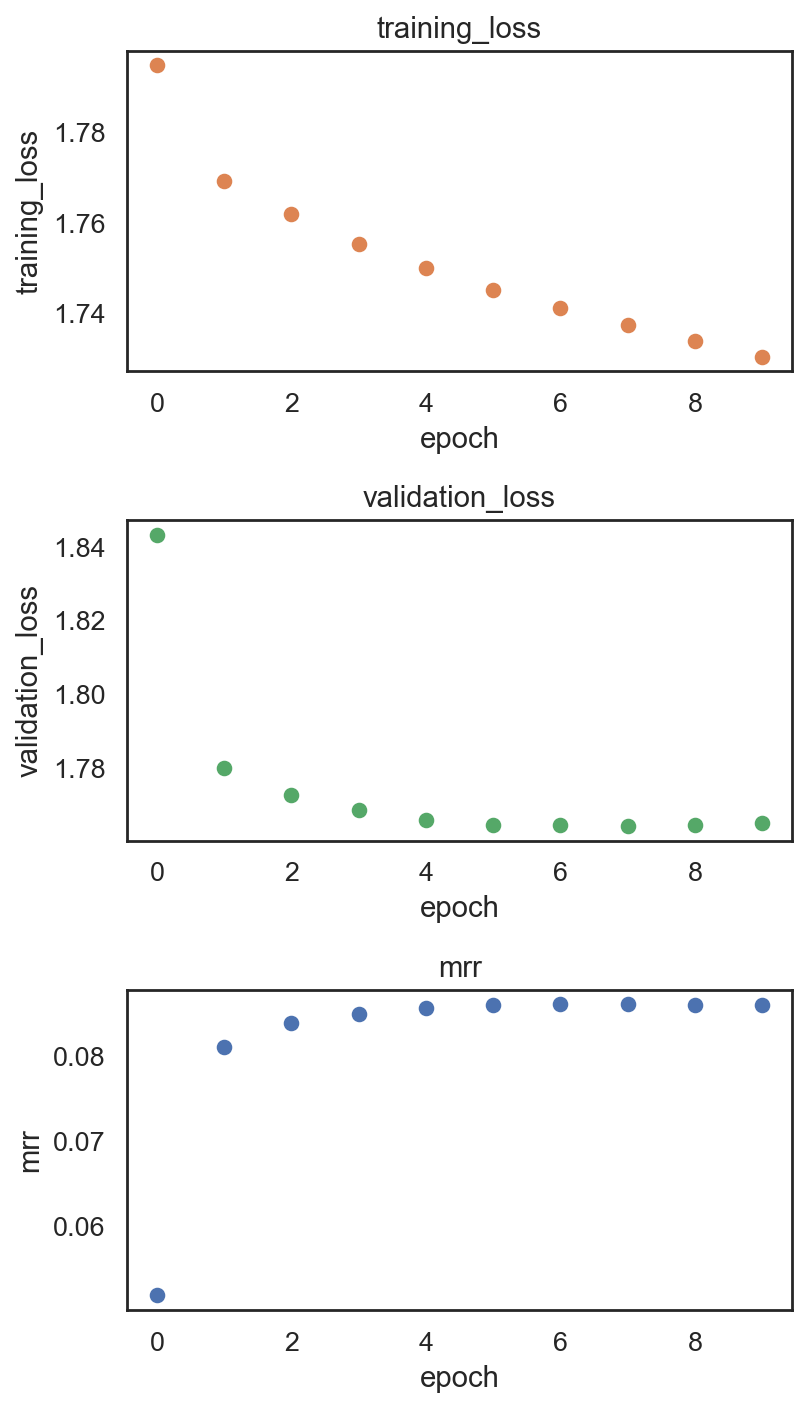

In [35]:
si.pl.pbg_metrics(fig_ncol=1)

In [31]:
si.settings.pbg_params['checkpoint_path']

'result_simba_atacseq/pbg/graph_weight_fixed_5/model_fixwd'

### post-training analysis

In [32]:
palette_celltype={'HSC':"#00441B", 'MPP':"#46A040", 'LMPP':"#00AF99", 'CMP':"#FFC179",'CLP':"#98D9E9",
                  'MEP':"#F6313E", 'GMP':"#FFA300", 'pDC':"#C390D4", 'mono':"#FF5A00",'UNK':"#333333"}

In [33]:
dict_adata = si.read_embedding(get_marker_significance=True)

Null feature nodes for entity C not embedded.


In [34]:
dict_adata

{'M': AnnData object with n_obs × n_vars = 601 × 50,
 'nM': AnnData object with n_obs × n_vars = 3005 × 50,
 'K': AnnData object with n_obs × n_vars = 3601 × 50,
 'nK': AnnData object with n_obs × n_vars = 18005 × 50,
 'C': AnnData object with n_obs × n_vars = 2034 × 50,
 'P': AnnData object with n_obs × n_vars = 134535 × 50,
 'nP': AnnData object with n_obs × n_vars = 134535 × 50}

In [35]:
adata_C = dict_adata['C']  # embeddings for cells
adata_P = dict_adata['P']  # embeddings for peaks
adata_M = dict_adata['M']  # embeddings for motifs
adata_K = dict_adata['K']  # embeddings for kmers
adata_nP = dict_adata['nP']
adata_nM = dict_adata['nM']  # embeddings for motifs
adata_nK = dict_adata['nK']  # embeddings for kmers

In [36]:
adata_nP

AnnData object with n_obs × n_vars = 134535 × 50

In [37]:
adata_nM

AnnData object with n_obs × n_vars = 3005 × 50

In [38]:
adata_nK

AnnData object with n_obs × n_vars = 18005 × 50

In [43]:
marker_tfs = ['PAX5', 'EBF1', # CLP
              'TCF12(var.2)', 'IRF8', 'TCF4',#pDC
              'CEBPB','CEBPD', #mono
              'MEIS1(var.2)', 'HOXA9', 'HOXA4',#HSC
              'GATA1', 'GATA3', #MEP
              'ATF4','STAT1',#CMP
              'ETV6', #GMP
             ]

marker_kmers = ['GATAAG', # GATA1
                'CAGCTG', # TCF4/TCF12
                'ATAAAT', # HOXA9
                'AGGAAA', # STAT1
                'CACTTC', #ETV6
               ]

marker_peaks = ['chr19_12997999_12998154', #KLF1
                'chr19_12998329_12998592', #KLF1
               ]

SIMBA metrics

In [40]:
# peaks
adata_cmp_CP = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_P, adata_query_null= adata_nP)

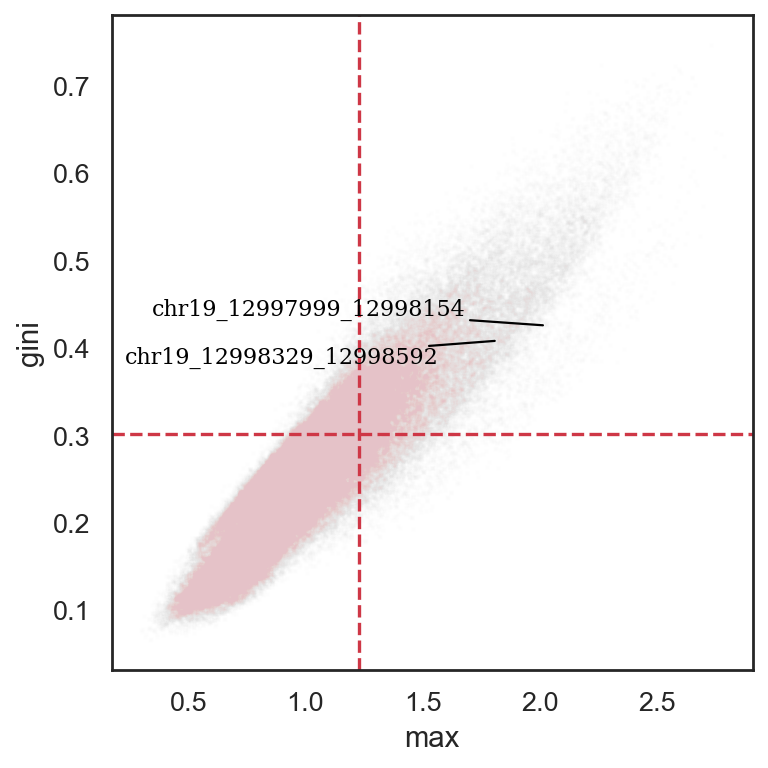

In [57]:
si.pl.entity_metrics(adata_cmp_CP,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     texts=marker_peaks,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_fdr=0.1,
                     c='#e5c2c8',
                     save_fig=False,
                    alpha=0.01)

In [81]:
si.pl.entity_metrics(adata_cmp_CP,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     texts=marker_peaks,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_fdr=0.1,
                     c='#e5c2c8',
                     alpha=0.02,
                     save_fig=True,
                     fig_name='entity_metrics_peaks.pdf',
                     rasterized=True
                    )

In [47]:
# motifs
adata_cmp_CM = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_M,
                                     adata_query_null=adata_nM)

In [48]:
adata_cmp_CM

AnnData object with n_obs × n_vars = 2034 × 601
    var: 'max', 'maxmin', 'std', 'gini', 'entropy', 'max_p', 'max_fdr', 'std_p', 'std_fdr', 'gini_p', 'gini_fdr', 'entropy_p', 'entropy_fdr'
    layers: 'norm', 'softmax'

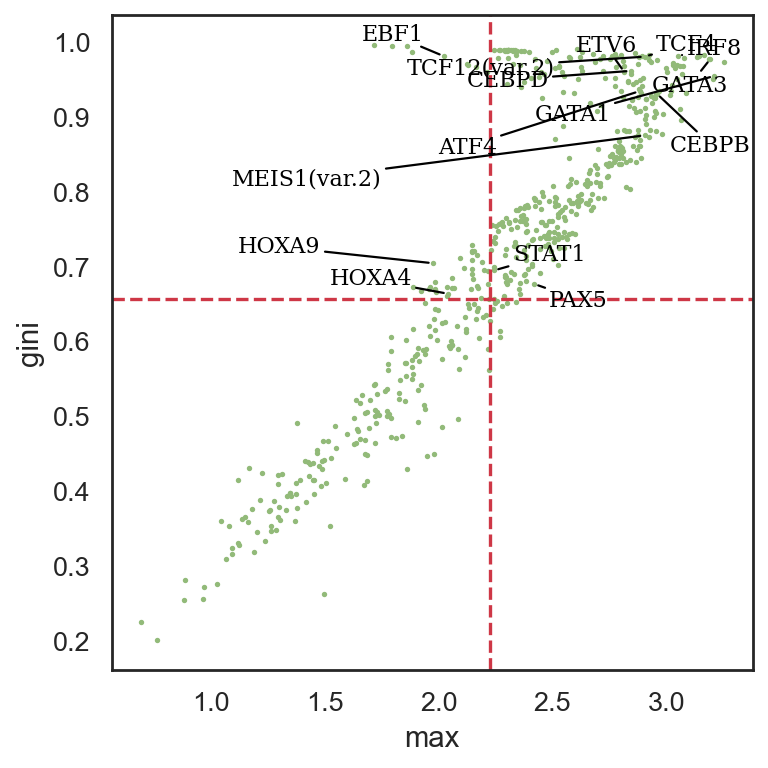

In [70]:
si.pl.entity_metrics(adata_cmp_CM,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     texts=marker_tfs,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_fdr=0.1,
                     c='#92ba79',
                     save_fig=False,
                    )

In [71]:
si.pl.entity_metrics(adata_cmp_CM,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     texts=marker_tfs,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_fdr=0.1,
                     c='#92ba79',
                     save_fig=True,
                    fig_name='entity_metrics_motifs_fdr0.1.pdf')

In [50]:
# kmers
adata_cmp_CK = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_K,
                                     adata_query_null=adata_nK)


In [51]:
adata_cmp_CK.shape

(2034, 3601)

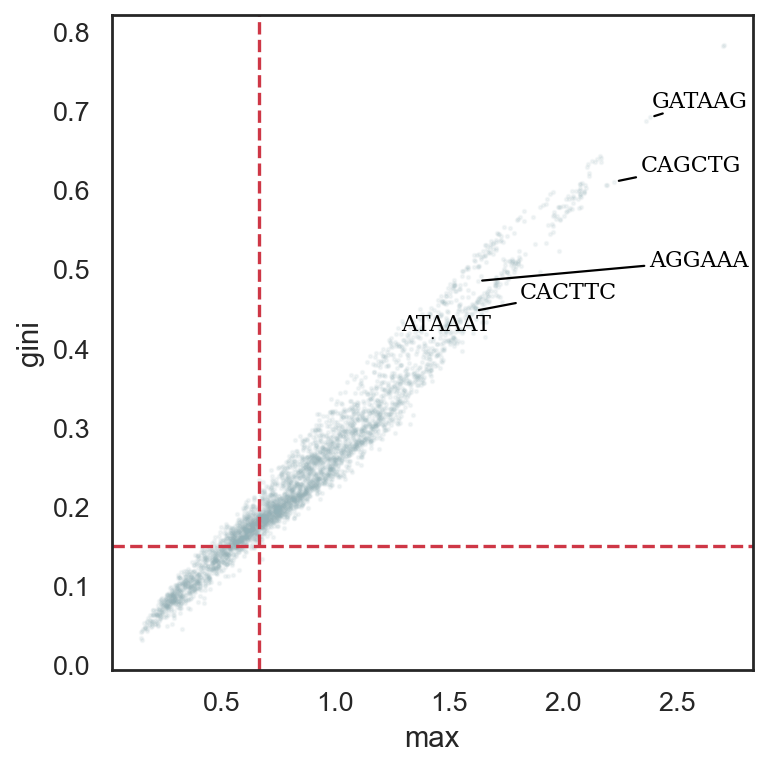

In [67]:
si.pl.entity_metrics(adata_cmp_CK,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     texts=marker_kmers,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_fdr=0.1,
                     c='#94b1b7',
                     alpha=0.1,
                     save_fig=False)

In [83]:
si.pl.entity_metrics(adata_cmp_CK,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     texts=marker_kmers,
                     text_expand=(1.5,1.5),
                     size=2,
                     cutoff_fdr=0.1,
                     c='#94b1b7',
                     alpha=0.1,
                     save_fig=True,
                     rasterized=True,
                     fig_name='entity_metrics_kmers.pdf')

### save results

In [76]:
adata_CP.write(os.path.join(workdir, 'adata_CP.h5ad'))
adata_PM.write(os.path.join(workdir, 'adata_PM.h5ad'))
adata_PK.write(os.path.join(workdir, 'adata_PK.h5ad'))

adata_C.write(os.path.join(workdir, 'adata_C.h5ad'))
adata_P.write(os.path.join(workdir, 'adata_P.h5ad'))
adata_K.write(os.path.join(workdir, 'adata_K.h5ad'))
adata_M.write(os.path.join(workdir, 'adata_M.h5ad'))

adata_nP.write(os.path.join(workdir, 'adata_nP.h5ad'))
adata_nK.write(os.path.join(workdir, 'adata_nK.h5ad'))
adata_nM.write(os.path.join(workdir, 'adata_nM.h5ad'))

adata_cmp_CM.write(os.path.join(workdir,'adata_cmp_CP.h5ad'))
adata_cmp_CM.write(os.path.join(workdir,'adata_cmp_CM.h5ad'))
adata_cmp_CK.write(os.path.join(workdir,'adata_cmp_CK.h5ad'))

Read back anndata objects
```python
adata_CP = si.read_h5ad(os.path.join(workdir, 'adata_CP.h5ad'))
adata_PM = si.read_h5ad(os.path.join(workdir, 'adata_PM.h5ad'))
adata_PK = si.read_h5ad(os.path.join(workdir, 'adata_PK.h5ad'))
adata_C = si.read_h5ad(os.path.join(workdir, 'adata_C.h5ad'))
adata_P = si.read_h5ad(os.path.join(workdir, 'adata_P.h5ad'))
adata_K = si.read_h5ad(os.path.join(workdir, 'adata_K.h5ad'))
adata_M = si.read_h5ad(os.path.join(workdir, 'adata_M.h5ad'))
adata_all = si.read_h5ad(os.path.join(workdir,'adata_all.h5ad'))
adata_cmp_CM = si.read_h5ad(os.path.join(workdir,'adata_cmp_CM.h5ad'))
adata_cmp_CK = si.read_h5ad(os.path.join(workdir,'adata_cmp_CK.h5ad'))
```